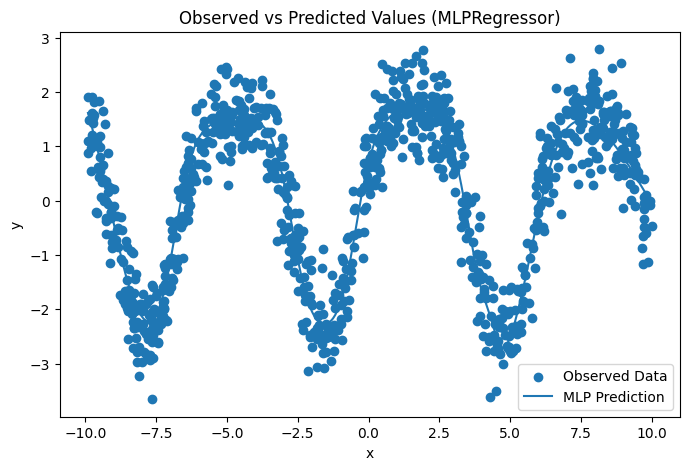

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------------------
# 1. Load dataset
# -------------------------------------
df = pd.read_csv('mlp.csv')  # update path if needed

X = df[['x']].values
y = df['y'].values

# -------------------------------------
# 2. Normalize/scale the data
# -------------------------------------
#scaler = StandardScaler()
X_scaled = StandardScaler().fit_transform(X)

# -------------------------------------
# 3. Split the data (train/test)
# -------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# -------------------------------------
# 4. Define and train the MLPRegressor
# -------------------------------------
model = MLPRegressor(
    hidden_layer_sizes=(16, 16),   # two hidden layers
    activation='tanh',             # good for non-linear patterns
    solver='adam',
    learning_rate_init=0.01,
    max_iter=5000,
    random_state=42
)

model.fit(X_train, y_train)

# -------------------------------------
# 5. Predict
# -------------------------------------
y_pred = model.predict(X_scaled)

# Sort for smooth plotting
sort_idx = np.argsort(X.flatten())
x_sorted = X.flatten()[sort_idx]
y_pred_sorted = y_pred[sort_idx]

# -------------------------------------
# 6. Visualization
# -------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(X, y, label="Observed Data")
plt.plot(x_sorted, y_pred_sorted, label="MLP Prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observed vs Predicted Values (MLPRegressor)")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, RFE #filter
from sklearn.linear_model import LinearRegression #wrapper
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# load
df = pd.read_csv("/workspaces/pyBob/testprep/housing.csv")

# simple preprocessing
df = df.copy()
df.replace({"yes": 1, "no": 0}, inplace=True)                   # binary yes/no -> 1/0
df = pd.get_dummies(df, columns=["furnishingstatus"], drop_first=True)  # categorical -> dummies

# features / target
y = df["price"].values
X = df.drop(columns=["price"])

# scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# choose k
k = min(6, X_scaled.shape[1])

# SelectKBest (filter)
skb = SelectKBest(score_func=f_regression, k=k).fit(X_scaled, y)
skb_features = list(X_scaled.columns[skb.get_support()])
print("SelectKBest selected features (k={}):".format(k))
for f in skb_features:
    print(" -", f)

# RFE (wrapper) with LinearRegression
est = LinearRegression()
rfe = RFE(estimator=est, n_features_to_select=k).fit(X_scaled, y)
rfe_features = list(X_scaled.columns[rfe.support_])
print("\nRFE selected features (n={}):".format(k))
for f in rfe_features:
    print(" -", f)

# quick comparison: cross-validated R2 using selected features
def cv_r2(features):
    scores = cross_val_score(LinearRegression(), X_scaled[features], y, cv=5, scoring="r2")
    return scores.mean()

print("\nCV R2 (SelectKBest) =", round(cv_r2(skb_features), 4))
print("CV R2 (RFE)        =", round(cv_r2(rfe_features), 4))

/tmp/ipykernel_19857/1158899571.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"yes": 1, "no": 0}, inplace=True)                   # binary yes/no -> 1/0


SelectKBest selected features (k=6):
 - area
 - bedrooms
 - bathrooms
 - stories
 - airconditioning
 - parking

RFE selected features (n=6):
 - area
 - bathrooms
 - stories
 - airconditioning
 - parking
 - prefarea

CV R2 (SelectKBest) = -11.7871
CV R2 (RFE)        = -10.134


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load
df = pd.read_csv("/workspaces/pyBob/testprep/insurance.csv")

# Encode categorical variables
X = df.drop(columns=["charges"])
X = pd.get_dummies(X, drop_first=True)  # encodes sex, smoker, region
y = df["charges"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardise (fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Feature selection (filter: top-k by univariate regression)
k = min(6, X_train_s.shape[1])
skb = SelectKBest(score_func=f_regression, k=k).fit(X_train_s, y_train)
selected_cols = list(X.columns[skb.get_support()])
print("Selected features:", selected_cols)

# Keep selected features
Xtr = skb.transform(X_train_s)
Xte = skb.transform(X_test_s)

# Fit linear regression
lr = LinearRegression().fit(Xtr, y_train)
y_pred_lr = lr.predict(Xte)

# Fit MLP (multi-layer) regressor
mlp = MLPRegressor(hidden_layer_sizes=(50,25), activation="relu",
                   solver="adam", learning_rate_init=0.001,
                   max_iter=1000, random_state=42)
mlp.fit(Xtr, y_train)
y_pred_mlp = mlp.predict(Xte)

# Evaluation helper
def eval(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

mse_lr, mae_lr, rmse_lr, r2_lr = eval(y_test, y_pred_lr)
mse_mlp, mae_mlp, rmse_mlp, r2_mlp = eval(y_test, y_pred_mlp)

print(f"\nLinearRegression: MSE={mse_lr:.2f} MAE={mae_lr:.2f} RMSE={rmse_lr:.2f} R2={r2_lr:.3f}")
print(f"MLPRegressor    : MSE={mse_mlp:.2f} MAE={mae_mlp:.2f} RMSE={rmse_mlp:.2f} R2={r2_mlp:.3f}")

# Sample predictions
print("\nSample predictions (first 5):")
for i in range(5):
    print(f"actual={y_test[i]:.2f}  lr_pred={y_pred_lr[i]:.2f}  mlp_pred={y_pred_mlp[i]:.2f}")

Selected features: ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_southeast']

LinearRegression: MSE=33816742.79 MAE=4200.07 RMSE=5815.22 R2=0.782
MLPRegressor    : MSE=28533095.51 MAE=3662.02 RMSE=5341.64 R2=0.816

Sample predictions (first 5):
actual=9095.07  lr_pred=8591.37  mlp_pred=8650.97
actual=5272.18  lr_pred=7039.29  mlp_pred=6921.46
actual=29330.98  lr_pred=36854.94  mlp_pred=37811.08
actual=9301.89  lr_pred=9451.30  mlp_pred=8222.22
actual=33750.29  lr_pred=26962.19  mlp_pred=27095.42


/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


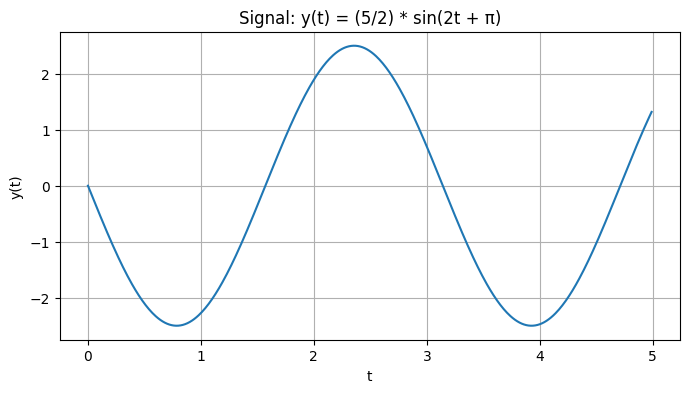

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate t values
t = np.arange(0, 5, 0.01)

# Compute y(t)
y = (5/2) * np.sin(2*t + np.pi)

# Plot the signal
plt.figure(figsize=(8,4))
plt.plot(t, y)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("Signal: y(t) = (5/2) * sin(2t + π)")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 1. Load & remove missing values
df = pd.read_csv("/workspaces/pyBob/testprep/penguins.csv")
df = df.dropna()  # remove rows with any missing values

# 2. Feature selection (use numeric measurements; keep top-3 by variance)
num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
df_num = df[num_cols].astype(float)
var_sorted = df_num.var().sort_values(ascending=False)
k_sel = 3
selected = var_sorted.index[:k_sel].tolist()
print("Selected features:", selected)

# 3. Standardise
scaler = StandardScaler()
Xs = scaler.fit_transform(df_num[selected])

# 4. Choose optimal k using silhouette score (k=2..6)
ks = range(2, 7)
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xs)
    sil_scores.append(silhouette_score(Xs, labels))
sil_by_k = dict(zip(ks, [round(s,3) for s in sil_scores]))
print("Silhouette scores:", sil_by_k)
best_k = ks[int(np.argmax(sil_scores))]
print("Chosen k =", best_k)

# 5. Fit final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(Xs)
labels = kmeans.labels_

# 6. Visualise clusters (PCA to 2D)
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(Xs)
centers2 = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=labels, cmap="tab10", s=40, alpha=0.8)
plt.scatter(centers2[:,0], centers2[:,1], c="black", s=100, marker="x")
plt.title(f"KMeans clusters (k={best_k}) — PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# Save results
df_out = df.copy()
df_out["cluster"] = labels
df_out.to_csv("/workspaces/pyBob/testprep/penguins_clusters.csv", index=False)
print("Saved: /workspaces/pyBob/testprep/penguins_clusters.csv")
```# filepath: /workspaces/pyBob/testprep/penguins_kmeans.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 1. Load & remove missing values
df = pd.read_csv("/workspaces/pyBob/testprep/penguins.csv")
df = df.dropna()  # remove rows with any missing values

# 2. Feature selection (use numeric measurements; keep top-3 by variance)
num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
df_num = df[num_cols].astype(float)
var_sorted = df_num.var().sort_values(ascending=False)
k_sel = 3
selected = var_sorted.index[:k_sel].tolist()
print("Selected features:", selected)

# 3. Standardise
scaler = StandardScaler()
Xs = scaler.fit_transform(df_num[selected])

# 4. Choose optimal k using silhouette score (k=2..6)
ks = range(2, 7)
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xs)
    sil_scores.append(silhouette_score(Xs, labels))
sil_by_k = dict(zip(ks, [round(s,3) for s in sil_scores]))
print("Silhouette scores:", sil_by_k)
best_k = ks[int(np.argmax(sil_scores))]
print("Chosen k =", best_k)

# 5. Fit final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(Xs)
labels = kmeans.labels_

# 6. Visualise clusters (PCA to 2D)
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(Xs)
centers2 = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=labels, cmap="tab10", s=40, alpha=0.8)
plt.scatter(centers2[:,0], centers2[:,1], c="black", s=100, marker="x")
plt.title(f"KMeans clusters (k={best_k}) — PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# Save results
df_out = df.copy()
df_out["cluster"] = labels
df_out.to_csv("/workspaces/pyBob/testprep/penguins_clusters.csv", index=False)
print("Saved: /workspaces/pyBob/testprep/penguins_clusters.csv")